In [1]:
import numpy as np

# Figure 2AC - Raw activity plots

In [2]:
import json

N_PFC_NEURONS = 500

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"
s_trial = 0
t_trial = 4800

# each neuron's activity is a row; column index is trial number
n_trials = t_trial - s_trial
rPFC_trials = np.zeros((n_trials, 200, N_PFC_NEURONS))
output_choice = np.zeros(n_trials)
task_input = np.zeros((2, n_trials))
q_values = np.zeros((2, n_trials))

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
        
        # NOTE: We are only considering the cue period for analysis
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        rOutput = np.array(data["network_rates"]["r_output"])
        trial_output_choice = np.mean(rOutput, axis=0).argmax(0)
        output_choice[idx] = trial_output_choice
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]
        q_values[:,idx] = trial_task_input[2:]


In [3]:
def plot_stderr(ax, x, c, l):
    m = np.mean(x, 0)
    stderr = stats.sem(x, 0)
    ax.plot(m, c, label=l)
    ax.plot(m + stderr, 'grey')
    ax.plot(m - stderr, 'grey')
    
def make_plot(neuron_idx, rPFC_trials, cue, v1, v2, choice, model_fit):
    CUE_TIME = 100

    fig = plt.figure(figsize=(22,12))

    # Plot over all trials
    ax1 = fig.add_subplot(2, 4, 1)
    neuron_activity = rPFC_trials[:,:]
    plot_stderr(ax1, neuron_activity, 'k', 'all trials')
    ax1.axvline(CUE_TIME, color='r', linestyle=':')
    ax1.set_title("Average trial activity")
    ax1.legend()

    # Plot cue UP trials vs cue DOWN trials
    ax2 = fig.add_subplot(2, 4, 2, sharey=ax1)
    cue_is_up = cue == 1
    cue_is_down = cue == -1
    cue_up_activity = rPFC_trials[cue_is_up,:CUE_TIME]
    cue_down_activity = rPFC_trials[cue_is_down,:CUE_TIME]
    plot_stderr(ax2, cue_up_activity, 'blue', 'Cue=UP')
    plot_stderr(ax2, cue_down_activity, 'orange', 'Cue=DOWN')
    ax2.set_title("Cue (UP vs DOWN)")
    ax2.legend()

    # Plot choice UP trials vs choice DOWN trials
    ax3 = fig.add_subplot(2, 4, 3, sharey=ax1)
    choice_is_up = [c == 1 for c in choice]
    choice_is_down = [c == -1 for c in choice]
    choice_up_activity = rPFC_trials[choice_is_up,:CUE_TIME]
    choice_down_activity = rPFC_trials[choice_is_down,:CUE_TIME]
    plot_stderr(ax3, choice_up_activity, 'blue', "Choice=UP")
    plot_stderr(ax3, choice_down_activity, 'orange', "Choice=DOWN")
    ax3.set_title("Behavioral Choice (UP vs DOWN)")
    ax3.legend()

    # Plot choice MATCH trials vs chocie NON-MATCH trials
    ax4 = fig.add_subplot(2, 4, 4, sharey=ax1)
    choice_is_match = np.equal(cue, choice)
    choice_match_activity = rPFC_trials[choice_is_match,:CUE_TIME]
    choice_is_nmatch = np.invert(choice_is_match)
    choice_nmatch_activity = rPFC_trials[choice_is_nmatch,:CUE_TIME]
    plot_stderr(ax4, choice_match_activity, 'blue', "Strat=MATCH")
    plot_stderr(ax4, choice_nmatch_activity, 'orange', "Strat=NON-MATCH")
    ax4.set_title("Strategy (MATCH vs NON-MATCH)")
    ax4.legend()

    # Plot V1 (and V2) vs average activity in 2nd half of choice 
    m_activity_late_cue = np.mean(rPFC_trials[:,math.floor(CUE_TIME/2):CUE_TIME],1)
    ax5 = fig.add_subplot(2, 4, 5)
    ax5.scatter(m_activity_late_cue, v1)
    ax5.set_title("Activity vs V1 per trial")
    ax5.set_xlabel("Late cue avg activity")
    ax5.set_ylabel("V1 value")
    ax6 = fig.add_subplot(2, 4, 6, sharex=ax5, sharey=ax5)
    ax6.scatter(m_activity_late_cue, v2)
    ax6.set_title("Activity vs V2 per trial")
    ax6.set_xlabel("Late cue avg activity")
    ax6.set_ylabel("V2 value")

    # Plot regression bar plot
    pvalues = model_fit.pvalues
    ax7 = fig.add_subplot(2, 4, 7)
    ax7.bar(["b0", "v1", "cue", "choice", "strategy"], model_fit.params)
    ax7.set_ylabel("Beta")
    ax7.set_title(f"Regression Analysis (R^2={np.around(model_fit.rsquared,3)})")
    ax7.text(-.2, 0.03, f"p={np.around(pvalues[0],8)}", rotation=30.)
    ax7.text(0.8, 0.03, f"p={np.around(pvalues[1],8)}", rotation=30.)
    ax7.text(1.8, 0.03, f"p={np.around(pvalues[2],8)}", rotation=30.)
    ax7.text(2.8, 0.03, f"p={np.around(pvalues[3],8)}", rotation=30.)
    ax7.set_ylim(-1,1)
    
    return fig
    

[[ 1.   0.1  1.  -1.  -1. ]
 [ 1.   0.1 -1.  -1.   1. ]
 [ 1.   0.1  1.   1.   1. ]
 ...
 [ 1.   0.1  1.  -1.  -1. ]
 [ 1.   0.1  1.   1.   1. ]
 [ 1.   0.1 -1.  -1.   1. ]]
(250, 5) (250,) (250, 200)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 04 Feb 2021   Prob (F-statistic):                nan
Time:                        18:53:26   Log-Likelihood:                    inf
No. Observations:                 250   AIC:                              -inf
Df Residuals:                     246   BIC:                              -inf
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
         

Text(0.5, 0.98, 'Neuron idx = 22, trials = [550,800), assc level = 10')

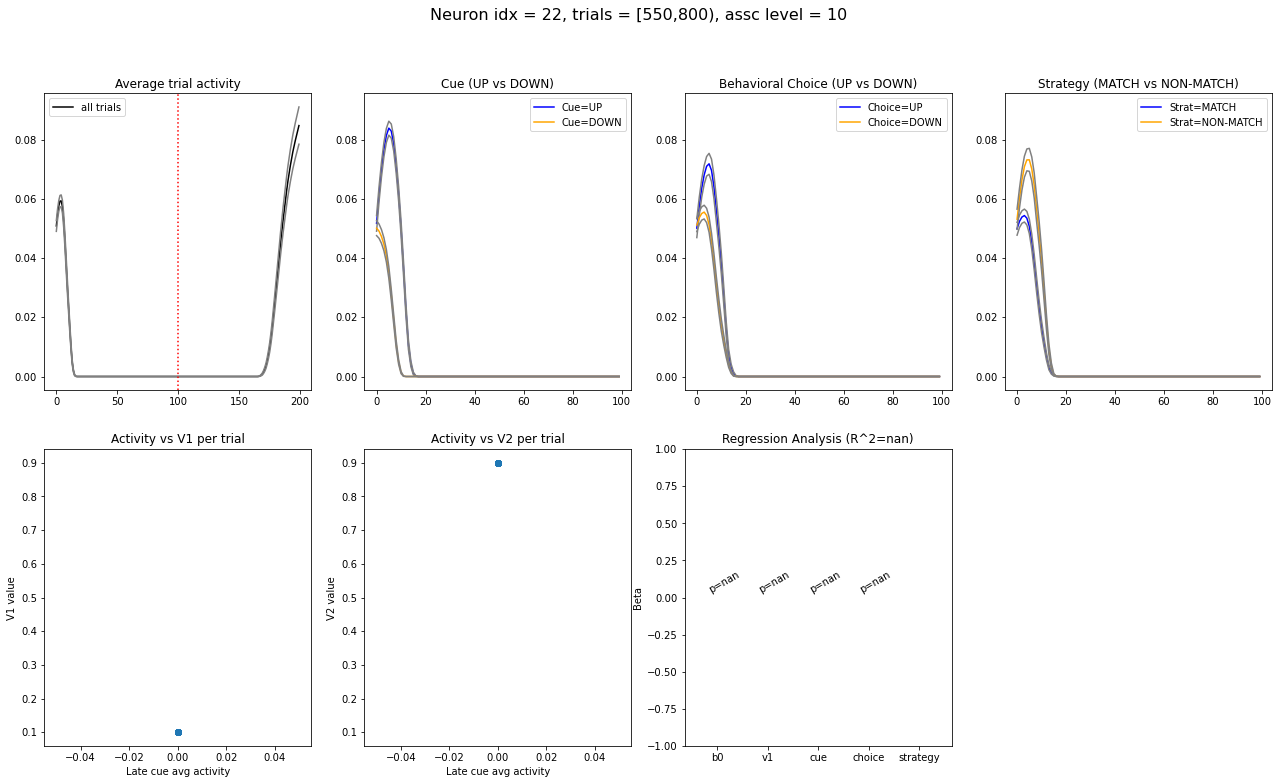

In [18]:
import statsmodels.api as sm
import math
from scipy import stats
import matplotlib.pyplot as plt

CUE_TIME = 100
ASSC_LEVELS = ['90', '10', '90', '70', '90', '10', '70', '30', '90', '50', '90', '10']
SAVE_DIR = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/neuron_figs"

for neuron_idx in range(0, 500, 10):
    print("Running neuron: " + str(neuron_idx))
    for n_bin in range(12): 
    trial_s = n_bin * 400 + 150
    trial_t = (n_bin + 1) * 400
    assc_level = ASSC_LEVELS[n_bin]

    cue = task_input[0,trial_s:trial_t]
    choice = output_choice[trial_s:trial_t]
    strategy = task_input[0,trial_s:trial_t] == choice
    v1 = q_values[0,trial_s:trial_t]
    v2 = q_values[1,trial_s:trial_t]
    rPFC_neuron = rPFC_trials[trial_s:trial_t,:,neuron_idx]

    cue[cue == 0] = -1
    choice[choice == 0] = -1
    strategy = [1 if is_match else -1 for is_match in strategy]

    X = np.transpose([np.ones(len(v1)), v1, cue, choice, strategy])
    y = np.mean(rPFC_neuron[:,math.floor(CUE_TIME/2):CUE_TIME],1)
    model = sm.OLS(y,X)
    model_fit = model.fit()

    fig = make_plot(neuron_idx, rPFC_neuron, cue, v1, v2, choice, model_fit)
    fig.suptitle(f"Neuron idx = {neuron_idx}, trials = [{trial_s},{trial_t}), assc level = {assc_level}", fontsize=16)

        plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}_s={trial_s}_t={trial_t}_a={assc_level}.jpg", transparent=False)
        plt.close()

# Regression analysis

In [ ]:
import json

N_PFC_NEURONS = 500

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/011921_file-per-trial/by_trial"
s_trial = 250
t_trial = 499

# each neuron's activity is a row; column index is trial number
n_trials = t_trial - s_trial + 1
rPFC_avg = np.zeros((N_PFC_NEURONS, n_trials))
output_choice = np.zeros(n_trials)
task_input = np.zeros((2, n_trials))
task_target = np.zeros((2, n_trials))

    
for i in range(s_trial, t_trial+1):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_cue = rPFC[:100,:] # NOTE: We are only considering the cue period for analysis
        trial_rPFC_avg = np.mean(rPFC_cue, axis=0).reshape(-1,1).flatten()
        
        rOutput = np.array(data["network_rates"]["r_output"])
        trial_output_choice = np.mean(rOutput, axis=0).argmax(0)
        
        trial_task_input = np.array(data["trial_data"]["input"])
        trial_task_target = np.array(data["trial_data"]["target"])
           
        idx = i - s_trial
        rPFC_avg[:,idx] = trial_rPFC_avg
        output_choice[idx] = trial_output_choice
        task_input[:,idx] = trial_task_input
        task_target[:,idx] = trial_task_target
        

In [51]:
import pandas as pd
import statsmodels.api as sm

dat = np.zeros((500, 3))

for i in range(0,500):
    neuron_idx = i

    # NOTE: For choice, inpt, and target 1 is UP and 0 is DOWN
    choice = output_choice
    inpt = task_input[1,:]
    target = task_target[1,:]
    trial_type = (inpt == target).astype(int)

    X = sm.add_constant(np.transpose([inpt, trial_type, choice]))
    y = rPFC_avg[neuron_idx,:]

    model = sm.OLS(y,X)
    results = model.fit()

    params = results.params
    rsquared = results.rsquared
    pvalues = results.pvalues
    
    dat[i,:] = params[1:]

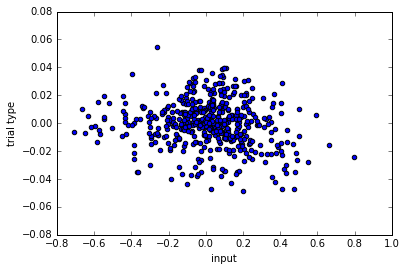

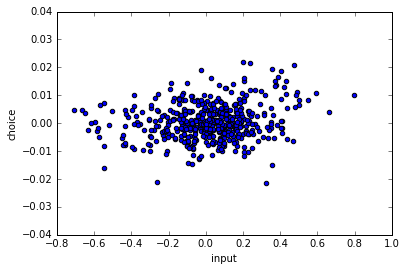

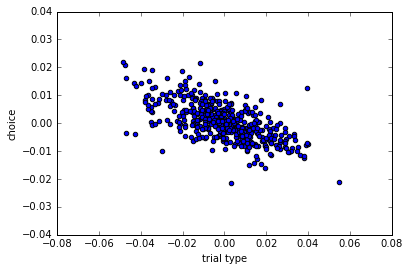

In [52]:
import matplotlib.pyplot as plt

plt.scatter(dat[:,0], dat[:,1])
plt.xlabel("input")
plt.ylabel("trial type")
plt.show()

plt.scatter(dat[:,0], dat[:,2])
plt.xlabel("input")
plt.ylabel("choice")
plt.show()

plt.scatter(dat[:,1], dat[:,2])
plt.xlabel("trial type")
plt.ylabel("choice")
plt.show()